In [35]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import random as rd
import numpy as np
import time
from typing import List
import pickle
import os 
import datetime
if os.getcwd() =='v6':
    os.chdir("RESULTADOS/comparacionDeTiempo") # Esta linea hace que el cuaderno corra sobre el directorio deseado
device = "cuda" # Esta linea hace que el cuaderno se ejecute con la gpu de envidia
dtype = torch.float64 # Esta linea hace que el tipo de dato sean floats de 64 bits


class NeuralNetworkPrueba(nn.Module): # Acá se declara el tipo de red que se va a usar
    def __init__(self):
        super(NeuralNetworkPrueba, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

redDinamica = NeuralNetworkPrueba().to(device) 


puntosAleatorios = torch.rand(40)
def actualizarPuntosAleatorios():
    global puntosAleatorios
    puntosAleatorios = torch.rand(40)*7
    

def solucionarPuntosAleatorios():
    pass

class ultimaComparacion():
    def __init__(self,tiempos,perdidas,promedios,nombresito):
        self.tiempos = tiempos
        self.registrosPerdidasGlobales = perdidas
        self.registroPromedios = promedios
        self.nombre = nombresito
        self.frecuenciaSampleo = 200 # Sampleo cada 200 datos
        pass
    def anadirDato(self,tiempo,perdida):
        self.tiempos.append(tiempo)
        self.registrosPerdidasGlobales.append(perdida)

metodoTradicional = []
metodoUsado = []

puntosPrueba = torch.linspace(0,7,400,requires_grad=True)
varPerdidaCondicionParada = 1e9


def perdidaParaRevisar():
    global varPerdidaCondicionParada
    with torch.no_grad():
        suma = 0
        for j in puntosPrueba:
            i = torch.tensor([j],device=device)
            y = redDinamica(i)
            suma += torch.abs(y-torch.sin(j))
    varPerdidaCondicionParada = suma
    return suma

varPerdidaUniforme = 1e2

def perdidaUniforme():
    global puntosAleatorios,varPerdidaUniforme
    suma = 0
    for j in puntosAleatorios:
        i = torch.tensor([j],device=device)
        print(i)
        y = redDinamica(i)
        print(y)
        return
        yprima=torch.autograd.grad(y,i,create_graph=True)[0]
        yprimaprima=torch.autograd.grad(yprima,i,create_graph=True)[0]
        suma+=(yprimaprima+y)**2
        #suma += torch.abs(y-torch.sin(j))
    x0 =  torch.tensor([0.0],device=device,requires_grad =True) # Ubicación en X de la primera condición de frontera
    xPi = torch.linspace(3.14159/2,1,2,device = device) 
    xPi =  torch.tensor([xPi[0]],device=device,requires_grad =True) # Ubicación en X se la segunda condición de frontera
    suma+=100*(redDinamica(x0))**2
    suma+=100*(1-redDinamica(xPi))**2
    varPerdidaUniforme = suma.item()
    return suma



def revisador():
    return varPerdidaCondicionParada<0.01*len(puntosPrueba)

In [16]:
puntosAleatorios[0]

tensor(0.4752)

In [41]:
def perdida2():
    global perdidavar # esta variable guarda la perdida en una ubicación afuera de la función.
    x0 =  torch.tensor([0.0],device=device,requires_grad =True) # Ubicación en X de la primera condición de frontera
    # el 0.0 es importante para que pytorch lo identifique como un float.
    # acá el argumento device se usa para indicar que el vector debe guardarse en la memoria de la gpu
    # Acá el rgumento requires_grad = true se usa para indicar que la variable importa a la hora de la diferenciación 
    xPi = torch.linspace(3.14159/2,1,2,device = device) 
    xPi =  torch.tensor([xPi[0]],device=device,requires_grad =True) # Ubicación en X se la segunda condición de frontera
    suma = 0
    for j in puntosAleatorios:
        i = torch.tensor([j],device=device,requires_grad =True) 
        # hay que meter el valor en X dentro de un vector para que pytorch lo tome como una operación de algebra lineal
        # lo anterior es necesario con la función nn.Sequential()
        y = redDinamica(i) 
        yprima=torch.autograd.grad(y,i,create_graph=True)[0]
        yprimaprima=torch.autograd.grad(yprima,i,create_graph=True)[0]
        suma+=(yprimaprima+y)**2
    # Acá se usa alpha = 100
    suma+=100*(redDinamica(x0))**2
    suma+=100*(1-redDinamica(xPi))**2
    perdidavar = suma
    return suma
perdida2()

tensor([76.5726], device='cuda:0', grad_fn=<AddBackward0>)

In [43]:
def plottear(filename_):
    if True:
            plt.figure(figsize = (20,10))
            ygrafica = []
            puntosGrafica = torch.linspace(0,10,250)
            for j in puntosGrafica:
                ytemp=redDinamica(torch.tensor([j],device = device))
                ygrafica.append(ytemp.cpu().detach().numpy()[0])
                #ygrafica.append(ytemp.detach().numpy()[0])
            import numpy as np
            puntosGrafica = np.linspace(0,10,250)
            plt.plot(puntosGrafica,ygrafica,label = "red")
            plt.plot(puntosGrafica,np.sin(puntosGrafica),label = "referencia",linestyle="-.")
            plt.plot(7,np.sin(7),marker = '|',ms= 10, label = 'Fin del dominio')
            plt.legend()
            plt.title(f"{i} epochs")
            plt.savefig(filename)
            plt.show(block = False)
            nombreParaGuardarRedIntermedia = "estados/uniforme "+str(i)+".tar"
            torch.save(redDinamica.state_dict(),nombreParaGuardarRedIntermedia)

0.10424695014953614


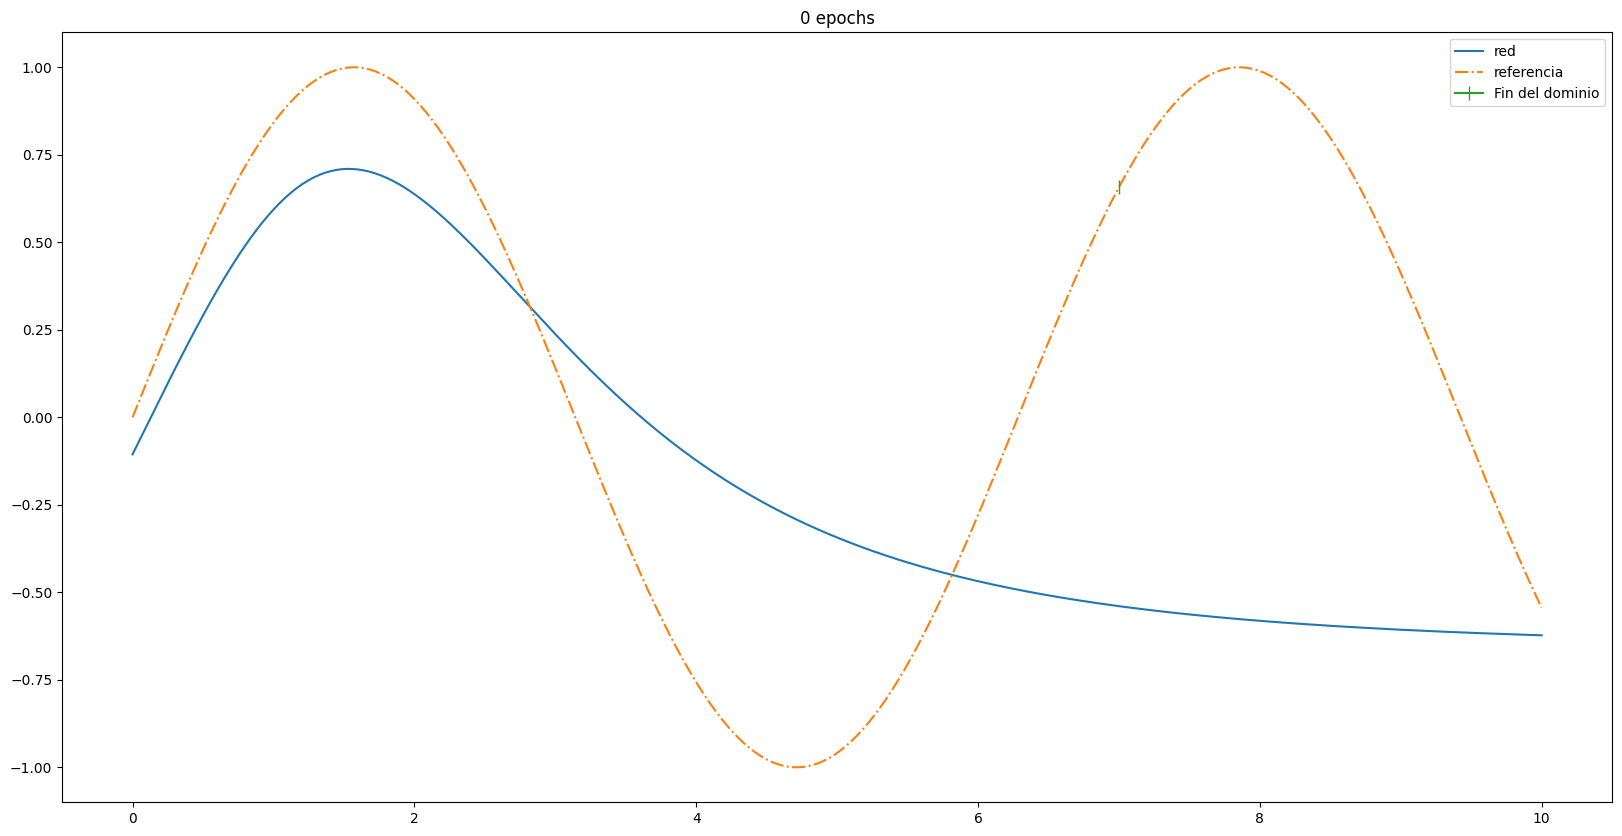

0.14243816137313842
0.0775648295879364
0.07390291690826416
0.09152343273162841


KeyboardInterrupt: 

In [45]:
filename = "uniformesprobra.tar"
ahora = datetime.datetime.now()
try:
    archivo = open(filename,"xb")
except:
    archivo = open(filename,"wb")
for ronda_solucion in range(20):
    optimizer = torch.optim.Adam(redDinamica.parameters(), lr=1e-3)
    registro_perdida=[]
    registro_promedio=[]
    registro_tiempo = []
    tiempoInicial = time.time()
    i = 0
    termino = False
    while  not termino and tiempoInicial+3600*10>time.time() :
        # Compute prediction and loss
        loss = perdida2()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(loss.item()/len(puntosAleatorios))
            actualizarPuntosAleatorios()
        if i % 20 == 0:
            if True:
                registro_perdida.append(perdidaParaRevisar().item()/len(puntosAleatorios))
                registro_promedio.append(-1)
                registro_tiempo.append(time.time()-tiempoInicial)
            else:
                inutil = perdidaParaRevisar().item()/len(puntos)
            termino = revisador()
        if i % 200 == 0:
            filename = f"graficas/{ahora.year}-{ahora.month}-{ahora.day}-{ahora.hour}-{ahora.minute}-PROC-Epoch:{i}-{ronda_solucion}"
            plottear(filename)
        i+=1
    metodoTradicional.append(ultimaComparacion(
                                                registro_tiempo,
                                                registro_perdida,
                                                registro_promedio,
                                                f"uniforme {i}"
        ))
    print("TERMINO")
    plottear()
    redDinamica = NeuralNetworkPrueba().to(device) 
pickle.save(metodoTradicional,archivo)
archivo.close

In [27]:
puntosAleatorios

tensor([1.5767, 0.9303, 5.8282, 4.6776, 4.5140, 3.2960, 1.6827, 0.3265, 3.5064,
        4.3227, 2.7260, 4.0647, 6.4852, 6.6241, 0.4081, 1.6615, 0.0760, 1.6346,
        2.9702, 1.0464, 4.2872, 5.2938, 3.7885, 0.2993, 1.4291, 4.9388, 0.0170,
        4.9583, 4.8073, 0.2983, 4.6054, 0.7358, 4.9774, 0.9078, 2.2326, 1.8962,
        0.1029, 3.9050, 2.4362, 5.9309])

In [26]:
actualizarPuntosAleatorios()

In [38]:
datetime.datetime.now()

datetime.datetime(2022, 11, 10, 15, 44, 47, 282685)

In [39]:
datetime.datetime.now().year

2022